Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [37]:
NAME = "Madhavi Pagare"
COLLABORATORS = ""

---

## CSCI-5931 : Deep Learning


In [38]:
import IPython
assert IPython.version_info[0] >= 3, "Your version of IPython is too old, please update it."

In [39]:
# === Imports === #
# Various python packages are used in this notebook. Please get yourself used to them (optional).
import pandas as pd  # used for storing a tabular representation of the dataset, similar to XLS files.
from pickle import dump  # used for saving class objects for access in another file
from pickle import load  # used for loading class objects for access in another file
from pathlib import Path # used to check if the saved model files and accessories.
import requests #used to request remote judge.csv evaluation 
from sklearn.preprocessing import StandardScaler  # used for normalization of dataset
from sklearn.model_selection import train_test_split  # used for performing the train-test split of a dataframe

from sklearn.preprocessing import OneHotEncoder   #My favorite categorical to numerical feature conversion tool
from tensorflow import keras  # keras used for construction of the Artificial neural network

import matplotlib.pyplot as plt  # used for training visualization
import numpy as np  # numpy arrays used for matrix computations

# === Extra Configurations for the GPU Environment === #
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
if len(physical_devices)>0: #If you have at least one "configured" GPU, let's use it; otherwise, pass
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# === Random Seed Initialization === #
random_seed = 54321  # will be passed into every function which accepts a random seed/state
                     # so that, all submissions will produce the same output.

## Read the full dataset

In [40]:
# In order to begin preprocessing the dataset, we must first read it into memory. 
#The below function reads the dataset into a pandas dataframe and returns that dataframe unprocessed. 
#This dataframe will be used as input for future functions.

def read_dataset( filepath ):
    '''
    input: 
       * filepath: string representation of path to file; mostly a csv file.
    
    returns: 
       * pandas dataframe containing the table present in 
         the dataset
    
     Task:
       * call the pandas package's read_csv function on the 
         specified filepath and return the result.
    '''
    return pd.read_csv( filepath )

# Task 1 : (5 points)
write a function that taskes as argument the csv datafile, and a string (denoting a column name belonging to the dataset). The function must call the read_dataset() function above and returns as a list 5 items: total number of rows, total number of columns, minimum, maximum, mean, standard deviation of the given column.

In [41]:
def lets_read_dataset(csv_file_name, column_name):
    """reads the csv file at csv_file_name, and particularly a column named column_name.
    Then, it computes 5 values: total number of rows in the csv, total number of columns in the csv,
    minimum, maximum, mean and standard deviation of values of the given column and
    sets the 5 variables below accordingly. And finally returns these 5 as a list []
    """
    
    total_number_of_rows = total_number_of_columns = minimum=maximum=mean=stdev = 0
    # YOUR CODE HERE
    #https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html    
    data = read_dataset(csv_file_name)
    total_number_of_rows = data[column_name].count()
    total_number_of_columns = data.columns.nunique()
    minimum = data[column_name].min()
    maximum = data[column_name].max()
    mean = data[column_name].mean()
    stdev = data[column_name].std()
    return [total_number_of_rows , total_number_of_columns , minimum, maximum, mean, stdev]

In [42]:
def sum_squared_difference(list1, list2):
    """Compute the sum of squared difference between elements from list1 and list2.
    This function is heavily used in Autograder test validations.
    """
    return np.sum( ( np.array(list1) - np.array(list2))**2 )

In [43]:
"""Check that lets_read_dataset returns the correct output for several inputs"""

assert  sum_squared_difference(lets_read_dataset('dataset/dataset.csv','CreditScore'),
                              [9000, 13, 350, 850, 650.1172222222223, 96.64063404096387]) <= 0.1

assert  sum_squared_difference(lets_read_dataset('dataset/dataset.csv','Age'),
                              [9000, 13, 18, 92, 38.921, 10.488982743812672]) <= 0.1


In [44]:
# === Enough of reading dataset... Haha. Let's settle down for now. Print the first 10 samples  === #
dataset = read_dataset( 'dataset/dataset.csv' )
dataset.head(n=10)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15647572,Greece,504,Spain,Male,34,0,54980.81,1,1,1,136909.88,0
1,15797692,Volkova,659,France,Female,33,7,89939.62,1,1,0,136540.09,0
2,15713559,Onyemauchechukwu,473,Germany,Female,32,5,146602.25,2,1,1,72946.95,0
3,15595067,Zhirov,637,Spain,Female,40,6,0.00,2,1,1,181610.60,0
4,15810167,Scott,657,Spain,Male,75,7,126273.95,1,0,1,91673.60,0
5,15730447,Anderson,629,France,Female,49,4,0.00,2,1,1,196335.48,0
6,15597309,Howell,749,Spain,Male,36,7,0.00,2,0,0,80134.65,0
7,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
8,15773949,Cherkasova,692,France,Female,36,3,0.00,2,1,1,8282.22,0
9,15610226,Fenton,614,France,Female,27,9,106414.57,2,0,0,77500.81,0


## Task 2 (10 points)

### First preprocessing that we are going to do is *Dropping selected Features (i.e., columns)*

Now that we have the dataset in memory, we can drop features as desired. The dropping of features will be performed in a function defined in the following code cell. Features dropped are specified in the markdown cell at the beginning of the preprocessing section. This operation will be done functionally with a new dataframe being returned with the specified features dropped.

In [45]:
def lets_drop_features( data , features_to_drop ):
    '''
    input: 
       * data: pandas dataframe to have features dropped
       * features_to_drop: list of columns (i.e., features) to be dropped.
    
    returns: 
       * pandas dataframe containing the original dataset without
         the specified features
    
    Task:
       * utilize pandas DataFrame.drop() function on the specified
         features
       * return the results as a new dataframe
    
    '''
#https://github.com/pycaret/pycaret/blob/master/pycaret/internal/preprocess.py
    # YOUR CODE HERE
    return data.drop(features_to_drop,axis=1)

In [46]:
def check_drop_features(csv_file,features_to_drop):
    '''
    An utility function to check your definition of lets_drop_features function.
    Returns True if the definition is correct, otherwise it returns false.
    '''
    data = read_dataset( csv_file )
    n_cols_before = len(data.columns)
    data = lets_drop_features(data,features_to_drop)
    n_cols_after = len(data.columns)
    
    so_far_so_good = True
    for feature_name in features_to_drop:
        if feature_name in data.columns:
            so_far_so_good = False
            break
    if so_far_so_good == True:
        if n_cols_before - n_cols_after != len(features_to_drop):
            so_far_so_good = False
    return so_far_so_good
    
    

In [47]:
"""Check that lets_drop_features returns the correct output for several inputs"""

assert  check_drop_features('dataset/dataset.csv',['Age']) == True

assert  check_drop_features('dataset/dataset.csv',['CustomerId' , 'Surname']) == True


In [48]:
# === Let's settle down with the dropping of features: 'CustomerId' and 'Surname' === #
features_to_drop = [ 'CustomerId' , 'Surname']
dataset_dropped  = lets_drop_features( dataset , features_to_drop )
dataset_dropped.head( n=10 )

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,504,Spain,Male,34,0,54980.81,1,1,1,136909.88,0
1,659,France,Female,33,7,89939.62,1,1,0,136540.09,0
2,473,Germany,Female,32,5,146602.25,2,1,1,72946.95,0
3,637,Spain,Female,40,6,0.00,2,1,1,181610.60,0
4,657,Spain,Male,75,7,126273.95,1,0,1,91673.60,0
5,629,France,Female,49,4,0.00,2,1,1,196335.48,0
6,749,Spain,Male,36,7,0.00,2,0,0,80134.65,0
7,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
8,692,France,Female,36,3,0.00,2,1,1,8282.22,0
9,614,France,Female,27,9,106414.57,2,0,0,77500.81,0


### Second Preprocessing that we are going to do is *Shuffle Rows*

"It is extremely important to shuffle the training data, so that you do not obtain entire minibatches of highly correlated examples. As long as the data has been shuffled, everything should work OK. Different random orderings will perform slightly differently from each other but this will be a small factor that does not matter much." -- [Ian Goodfellow](https://qr.ae/pGBgw8)

To shuffle, we will write a wrapper function to call pandas built in DataFrame.sample() with a frac parameter of 1 (Return 100% of the dataset after shuffling) and a random_state.

In [49]:
def shuffle_data( data , random_seed=12345 ):
    '''
    input: 
       * data: pandas dataframe to be shuffled
       * random_seed (optional): seed for the random state
            - Default = 12345
    
    returns: 
       * pandas dataframe containing a random shuffling of the
         rows of the data parameter
    
    Task:
       * use pandas DataFrame.sample() to select a random sample
         of the data parameter. By default, the data is sampled
         without replacement, so a frac=1 parameter will randomly
         select 100% of the data entries distinctly (shuffling).
         And using the random_seed parameter as the random_state
         for the sample. 
    
    Note:
       - In order to exclude the use of a random state,
         the random_seed parameter of this function must be
         set to None type.
    '''
    return data.sample( frac=1 , random_state=random_seed )


In [50]:
# === Demonstrate Success of the Shuffle === #
dataset_shuffled = shuffle_data( dataset_dropped , random_seed=random_seed )
dataset_shuffled.head( )

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
3801,637,Germany,Female,55,1,123378.20,1,1,0,81431.99,1
8694,685,Spain,Male,31,7,122449.31,2,1,1,180769.55,0
3163,584,France,Female,40,4,82441.75,1,0,0,80852.11,0
8298,645,France,Male,32,4,0.00,2,0,1,97628.08,0
6829,656,France,Female,46,5,113402.14,2,1,1,138849.06,0


## Task 3: (10 points)

### Third Preprocessing that we will do is X-y Partitioning of the dataset

In its current state, the dataset contains both independent (input) and the target features within the same dataframe. In order to be used in a keras model, we need to partition the training features from the target feature into two separate dataframes. This operation is performed within a custom function which returns a tuple of the form (X,y) where both X and y are the appropriate paritions.

In [51]:
def lets_do_Xy_partition( data , target_feature_name ):
    '''
    input: 
       * data: pandas dataframe to be partitioned
       * target_feature_name: string name of the column
         containing the target feature.
    
    returns: 
       * tuple of the form (X,y) where X is the data parameter
         with the target feature column dropped, and y is a 
         pandas dataframe containing only the target feature.
    '''
    X = y = []
   # https://github.com/JuliaML/MLDataPattern.jl
    # YOUR CODE HERE
    X = data.drop([target_feature_name],axis=1)
    y = data[[target_feature_name]]
    return X,y
    #raise NotImplementedError()


In [52]:
def check_Xy_partition(csv_file,target_feature):
    '''
    An utility function to check your definition of lets_do_Xy_partition function.
    Returns True if the definition is correct, otherwise it returns false.
    '''
    data = read_dataset( csv_file )
    data_shape_before = len(data.columns)
    X, y = lets_do_Xy_partition(data,target_feature)
    data_shape_after = len(data.columns)
    
    so_far_so_good = False
    if data_shape_before == data_shape_after: #should not change original dataset
        if isinstance(X, pd.DataFrame) and isinstance(y, pd.DataFrame): #both X, y needs to be dataframes
            if X.shape[1] == data.shape[1]-1 and y.shape[1]==1:
                 so_far_so_good = True
    return so_far_so_good

In [53]:
"""Check that lets_do_Xy_partition returns the correct output for several inputs"""

assert  check_Xy_partition('dataset/dataset.csv','Exited') == True



In [54]:
""" Finally, settle down with one last Xy partitioning... where Exited column is marked as target. """

X , y = lets_do_Xy_partition( dataset_shuffled , 'Exited' )


## Task 4 (10 points)
### Fourth Preprocessing that we will do is Train-Test Split of X, y

Now that we have X and y tables with appropriate feature pruning performed, we must split the data into a training partition (X_train, y_train) and a testing partition (X_test, y_test). 

The training partitions (X_train, y_train) will be used to train your model, while the test partition (X_test, y_test) will be used to evaluate the trained model. 

Training and test splits should be mutually exclusive to the datasets... i.e., a sample can not be both in the two splits.


Please use `sklearn.model_selection.train_test_split` function to conduct the splits. Please do a 80-20 split, meaning 80% of the (X,y) dataset will be in (X_train, y_train) split, while, remaining 20% will be in (X_test,y_test) split. 

Please do not forget to initialize `random_state` parameter of the train_test_split function to the `random_seed` we defined in the first cell of this notebook. This ensures replicable results, and easier to validate your code. 

In [55]:
# === Use Sklearn to Split the Data into Train and Test Sets === #
X_train = X_test = y_train = y_test = []

# YOUR CODE HERE
#from sklearn.model_selection import train_test_split
X_train, X_test, y_train , y_test = train_test_split(X,y,test_size=0.20)

#raise NotImplementedError()

In [56]:
def check_train_test_splits(X,y,X_train,y_train,X_test,y_test):
    '''
    An utility function to check your work to split (X,y) into (X_train,y_train) and (X_test,y_test) splits.
    Returns True if the definition is correct, otherwise it returns false.
    '''
    so_far_so_good = False
    if isinstance(X_train, pd.DataFrame) and \
        isinstance(X_test, pd.DataFrame) and \
            isinstance(y_train, pd.DataFrame) and \
                isinstance(y_test, pd.DataFrame):
        if len(X)*0.20== len(X_test) and len(y)*0.20==len(y_test):
            so_far_so_good = True
    return so_far_so_good
        

In [57]:
"""Check if your work on train test split of (X,y) is successful."""

assert  check_train_test_splits(X,y,X_train,y_train,X_test,y_test) == True

## Task 5 (10 points)

### Fifth preprocessing that we will do is the *Conversion of Categorical features to Numerical*
#### Preferrably Using One Hot Encoding

A little background first: Categorical features are features that contain values that are not numeric. It would be absurd to work with non-numeric features if you ask neurons in your ANN to compute the weighted sum of inputs, and then pass through activation function, right? These maths are undefined. An obvious solution you may be intrigued to do is dropping the features! Aha! Wrong!! Every piece of data is precious... may present with valuable insights of the data samples to find the patterns to map inputs with output/targets. So, we should include them. But, how?

The answer is via "Encoding". 
There several types of encoding used in practice.
1. **Label Encoding**, where labels are encoded as subsequent numbers. Say, for a categorical feature named "Category" with three categorical values: {“Cat”, “Dog” or “Zebra”} can be encoded to "0", "1", "2" respectively as in figure below. The issue with this type of encoding may unintentionally impose a type of ordering of the categories, that may add bias to the training.
![label-encoding](http://54.160.44.72/STATIC_FIGS_DO_NOT_MOVE/le.png)
2. **One Hot Encoding**, ignores the ordering of the categories all together. With one-hot, we convert each categorical value into a new categorical column and assign a binary value of 1 or 0 to those columns. Each integer value is represented as a binary vector. All the values are zero, and the index is marked with a 1. Also, don't forget to remove the original categorical features. Here below just an example, how to convert the categorical feature called "Category" having the {“Cat”, “Dog” or “Zebra”} values into three new binary features: "Cat", "Dog", "Zebra".
![label-encoding](http://54.160.44.72/STATIC_FIGS_DO_NOT_MOVE/ohe.png)

**A note on the Dummy Variable Trap**
The Dummy Variable Trap occurs when two or more dummy variables created by one-hot encoding are highly correlated (i.e., becomes multi-collinear). This means that one variable can be predicted from the others, making it difficult to interpret predicted coefficient variables in regression models. In other words, the individual effect of the dummy variables on the prediction model can not be interpreted well because of multicollinearity.

Using the one-hot encoding method, a new dummy variable is created for each categorical variable to represent the presence (1) or absence (0) of the categorical variable. For example, if tree species is a categorical variable made up of the values pine, or oak, then tree species can be represented as a dummy variable by converting each variable to a one-hot vector. This means that a separate column is obtained for each category, where the first column represents if the tree is pine and the second column represents if the tree is oak. Each column will contain a 0 or 1 if the tree in question is of the column's species. These two columns are multi-collinear since if a tree is pine, then we know it's not oak and vice versa. The machine learning models trained on dataset having this multi-collinearity suffers. A remedy is to drop first (or any one) of the dummy (i.e., one-hot) features created.

In [58]:
def lets_do_one_hot_encoding(data, categorical_features, transform_only=True, encoders=[]):
    '''
    The function does one_hot_encoding on the given dataset... 
    It's intentionally defined fully, meaning you do not need to do anything here... but show us
    how to use it properly.
    
    Input: 
        * data -- it's pretty much either X_train, or X_test that you prepared previously, that is
                  any dataframe having independent variables.
        * categorical_features -- a list of column/feature names in the data (dataframe) that you think
                  are non-numerical / i.e., categorical that you want to be converted to numerical
                  using the one-hot encoding technique.
        * transform_only -- a boolean parameter, if set to False, will learn (i.e., fit) various categorical
                values in the categorical_features from the given dataset, and use this to encode the dataset
                using one-hot encoding. This is important that you set to False on training dataset, and
                True on test set. If new categorical values are present in the test dataset, those will be
                ignored, making it easier to have same set of encoded features both in training and test 
                dataset... otherwise, subsequent operations (may/) will not work.
        * encoders -- a list of one-hot encoders previously saved, and now will be used to encode given dataset.
                If transform_only=True, the function looks for this provided list of encoders to encode the 
                dataset instead of learning new categories. Once again, it's expected that you pass the set
                of encoders for each of the categorical features that you encoded the training set -- i.e.,
                leave it empty for training set, and pass the set of encoders while encoding test set.
    Returns:
        * data -- the converted dataframe after the encoding is completed.
        * enc_list -- is the list of encoders used to encode the given data.
        * categorical_features -- is the list of categorical features that you would want to encode.
        It's expected that for training dataset, you save the encoder list and the list of features for later
        use to encode a test dataset.
    '''
    if len(encoders)>0:
        enc_list=encoders
    else:
        enc_list = []
    col_onehot = []
    i = 0
    for feature in categorical_features:
        if transform_only==True: #for test dataset
            enc = enc_list[i]
            c_onehot = enc.transform(data[[feature]])
            i = i + 1
        else: #fit and transform
            enc = OneHotEncoder(handle_unknown='ignore', drop='first', sparse=False)
            c_onehot = enc.fit_transform(data[[feature]])
            enc_list.append(enc)
        c_onehot = pd.DataFrame(c_onehot, columns=list(enc.categories_[0][1:])) #dropped first column
        col_onehot.append(c_onehot)
        
    #concat all onehot feature columns
    concat_df = pd.concat(col_onehot,axis=1)
    #match index with given data
    concat_df.index = data.index
    #drop the categorical feature columns
    data = lets_drop_features( data , features_to_drop=categorical_features )
    #merge with those new onehot features
    data = data.join(concat_df)
    return data,enc_list,categorical_features



In [59]:
'''
let's apply one-hot encoding on two columns: "Geography" and "Gender" of the training dataset, X_train.
Please make good use the function, lets_do_one_hot_encoding() defined above.
Also, receive the 3 return values from the function call to use them in the next question, that is,
encoding the test dataset, X_test. It's always a good idea to save the list of encoders and features
in file, if you would want to apply your model to evaluate/predict on a new test sample.

'''
X_train_ohe = []  #one-hot encoded training dataset
enc_list = [] #encoder list to be created during one-hot encoding of the training dataset
categorical_features = [] #The list of categorical features in question. The function call
                          #should return ["Geography", "Gender"]

# YOUR CODE HERE
#https://datascience.stackexchange.com/questions/71804/how-to-perform-one-hot-encoding-on-multiple-categorical-columns
#https://gist.github.com/ramhiser/982ce339d5f8c9a769a0
categorical_features = ["Geography","Gender"]
X_train_ohe, enc_list, categorical_features =  lets_do_one_hot_encoding(X_train, categorical_features, transform_only=False)
#raise NotImplementedError() 

In [60]:
'''
let's apply one-hot encoding on the same two columns: "Geography" and "Gender" of the test dataset, X_test.
Please make good use the function, lets_do_one_hot_encoding() defined above.
Also, receive the 3 return values from the function call. Although, the second and third returned values
can be ignored, if you like.

Please make sure, the one-hot encoded training set and test set has the exact same number of features/columns,
and in the same order. If not, the test in the next cell will almost certainly fail, and you will lose points,
and the training and testing of the Artificial Neural Network will absolutely fail. So, please take close
attention.

'''
X_test_ohe = []  #one-hot encoded training dataset


# YOUR CODE HERE
#https://github.com/christianversloot/machine-learning-articles/blob/main/one-hot-encoding-for-machine-learning-with-python-and-scikit-learn.md
X_test_ohe = lets_do_one_hot_encoding(X_test, categorical_features,True,enc_list)[0]
#raise NotImplementedError()

In [61]:
def check_one_hot_encoding(X_train_ohe,X_test_ohe):
    '''
    This utility function checks if one-hot encoding of training and test sets are correctly done.
    Returns true if its correct, otherwise returns false.
    '''
    
    so_far_so_good = True
    if isinstance(X_train_ohe,pd.DataFrame) and isinstance(X_test_ohe,pd.DataFrame):
        if (X_train_ohe.columns == X_test_ohe.columns).all == False:
            so_far_so_good = False
    else:
        so_far_so_good = False

    return so_far_so_good

In [62]:
"""Check if your work on One-hot encoding is successful."""

assert  check_one_hot_encoding(X_train_ohe,X_test_ohe) == True

## Task 6: (10 points)

### Sixth Preprocessing that we are going to do is *Normalization of X_train_ohe, and X_test_ohe*

Now that we all numerical training and test dataset, X_train_ohe and X_test_ohe respectively, we can normalize each features in both the dataset. **Normalization** is just one of the way to scale each feature. In class you'll learn a ton of other ways to scale. For this task, let's resort to **Normalization**.

"The rule of thumb for scaling datasets, is we scale training dataset first, then using the statistics that we learn during the scaling process, we scale the test dataset. We do not learn any statistics from the test dataset."

Also, scaling is commonly performed column-wise, and never sample/row wise.


Let's use normalization scheme from the package, `sklearn.preprocessing.Normalizer`. You could do this manually by subtracting mean of a column, followed by dividing by standard deviation of that column. You repeat this for all the columns in the given dtaset. 
Anyway, be sure to save the normalizer object that you will fit and transform the training set so that you first use it to scale the test set, or anytime a new test set is given.

In [63]:
# === Fit (i.e., learn) Sklearn's Normalizer to Our Data === #
normalizer = StandardScaler( ) #Construct the normalizer object

normalizer.fit( X_train_ohe ) # Fit (i.e., learn from the training dataset, X_train_ohe)

StandardScaler()

In [64]:
'''
Using the fitted normalizer object's member method, transform() normalize the training dataset, X_train_ohe.
Then, normalize the test dataset, X_test_ohe.
Save the scaled training and test sets into X_train_scaled, and X_test_scaled variables.
'''

X_train_scaled = []  
X_test_scaled = []

# YOUR CODE HERE
#https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/preprocessing/_data.py
#https://github.com/alod83/data-science/blob/master/Preprocessing/Normalization/Data%20Preprocessing%20-%20Normalization%20with%20scikit-learn.ipynb
X_train_scaled = normalizer.transform(X_train_ohe)
X_test_scaled = normalizer.transform(X_test_ohe)
#raise NotImplementedError()


In [65]:
def check_the_scaling(dataset):
    '''
    After normalization, mean of every column would be 0.0 (or close enough), and standard deviation 1.0
    This function will fail if you do something different.
    '''
    so_far_so_good = False
    if ((dataset.mean() - 0.0) < 0.0000001) and ((dataset.std() - 1.0) < 0.0000001):
        so_far_so_good = True
    
    return so_far_so_good

In [66]:
"""Check if your work on scaling of both X_train_ohe and X_test_ohe was in fact successful."""

assert  check_the_scaling(X_train_scaled) == True

"""Also, you will have left 11 columns for each of the datasets."""
assert X_train_scaled.shape[1] == 11 and X_test_scaled.shape[1] == 11

## Designing an ANN Using Keras

Design an artificial neural network, ANN using the Keras library. For reference, please take a look here [https://keras.io/getting-started/sequential-model-guide/](https://keras.io/getting-started/sequential-model-guide/). For simplicity, please use the `adam` optimizer and `binary_crossentropy` as the loss function the optimizer will use. Details will be presented later. Here, just use it.


### Keras ANN 1.1: Construct the Layers

The first step to define a model in Keras is to define the layers of neurons used by the model. The following cell will define each of these layers for the first network model, having the following architecture:

* Input layer will have 11 units as the dimension of training set (i.e, number of columns = 11).
* First hidden layer will have 5 neurons, each with "ReLU" as activation function (the popular one).
* Second hidden layer will have 4 neurons, each with "ReLU" as activation function.
* Output layer will have just 1 neuron, with sigmoid activation function. The reason being, output of this neuron will tell the probability score of the target outcome: "Exited" True or False. If the output neuron produces value above 0.5, we will say the neural network predicted "True", otherwise, False. THis is the beauty of using sigmoid function at the output layer as we can interpret the output as if it's probability.


In [67]:
layers = [
    keras.Input( shape=( X_train_scaled[0].shape ) ),  # Input Layer
    keras.layers.Dense(  5 , activation='relu'    , name='hidden-layer-1' ),  
    keras.layers.Dense(  4 , activation='relu'    , name='hidden-layer-2' ),  
    keras.layers.Dense(  1 , activation='sigmoid' , name='output-layer' )  
]

### Keras ANN 1.2: Compile the Model

Now that we have the layers list prepared, we must call compile() with specifications like which loss function to optimize to learn the weights of the network, and the name of the optimizer function. There are variations of gradient descent algorithm. You can also specify which evaluation metric to show during the training process. 

Let's optimize the `binary_corssentropy` as the loss function using the `adam` optimizer. We want the training function, i.e., `fit()` prints model accuracy for every epoch.

Also, let's print the compiled model which is ready to learn from the training dataset you would present to it.

In [68]:
# === Define the Model Object === #
ann_1 = keras.Sequential( layers=layers )

# === Compile the Model With Appropriate Parameters === #
ann_1.compile( loss='binary_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy'] )  # metric shown during training

# === Show Model Compiled Successfully by Printing Summary === #
ann_1.summary( )

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden-layer-1 (Dense)      (None, 5)                 60        
                                                                 
 hidden-layer-2 (Dense)      (None, 4)                 24        
                                                                 
 output-layer (Dense)        (None, 1)                 5         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


### Keras ANN 1.3 Train the Model

Let's start the training the training dataset, X_train_scaled by calling the `fit()` function through the ANN model, ANN-1. 

For simplicity, let's train for 25 epochs. If you are ambitious, you should run it longer! But, be warned, if you are running it without GPU support enabled at the beginning of the notebook, you need to wait a lot longer.

If you are curious to know the details what happened during the training, saving history, i.e, return value from the `fit()` may be a good idea.

In [69]:
# === Train While Recording History for Visualization === #
ann_1_history = ann_1.fit( X_train_scaled, 
                           y_train, 
                           epochs=25,
                           validation_data=( X_test_scaled , y_test ) )

Epoch 1/25
225/225 [==============================] - 5s 13ms/step - loss: 0.6223 - accuracy: 0.6978 - val_loss: 0.5172 - val_accuracy: 0.7911
Epoch 2/25
225/225 [==============================] - 1s 5ms/step - loss: 0.4760 - accuracy: 0.8033 - val_loss: 0.4690 - val_accuracy: 0.7944
Epoch 3/25
225/225 [==============================] - 1s 5ms/step - loss: 0.4477 - accuracy: 0.8058 - val_loss: 0.4490 - val_accuracy: 0.8000
Epoch 4/25
225/225 [==============================] - 1s 5ms/step - loss: 0.4345 - accuracy: 0.8089 - val_loss: 0.4370 - val_accuracy: 0.8033
Epoch 5/25
225/225 [==============================] - 1s 5ms/step - loss: 0.4259 - accuracy: 0.8124 - val_loss: 0.4271 - val_accuracy: 0.8117
Epoch 6/25
225/225 [==============================] - 1s 4ms/step - loss: 0.4183 - accuracy: 0.8176 - val_loss: 0.4178 - val_accuracy: 0.8161
Epoch 7/25
225/225 [==============================] - 1s 2ms/step - loss: 0.4108 - accuracy: 0.8251 - val_loss: 0.4086 - val_accuracy: 0.8222
Epoch

### Keras ANN 1.3 : Training Visualization

Let's visualize the model's training in order to achieve a better understanding of whether overfitting/underfitting may have occurred, or check on the performance in general (i.e., conduct a simple sanity check of the training). 

As observed in the accuracy chart, we begin to see a slight decline in the test accuracy after about 20 epochs, showing that there is overfitting occurring. 


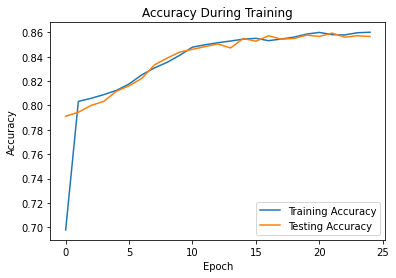

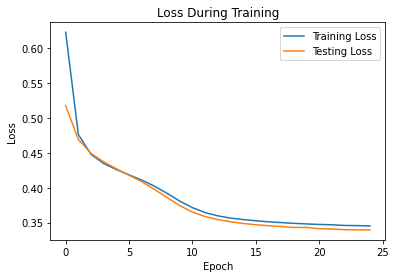

In [70]:
# === Plot the Accuracy === #
plt.figure( )
plt.plot( ann_1_history.history['accuracy']     , label='Training Accuracy' )
plt.plot( ann_1_history.history['val_accuracy'] , label='Testing Accuracy' )

# === Label the Chart === #
plt.xlabel( 'Epoch' )
plt.ylabel( 'Accuracy' )
plt.title( 'Accuracy During Training' )
plt.legend( )

# === Display the Chart === #
plt.show( )


# === Plot the Loss === #
plt.figure( )
plt.plot( ann_1_history.history['loss']     , label='Training Loss' )
plt.plot( ann_1_history.history['val_loss'] , label='Testing Loss' )

# === Label the Chart === #
plt.xlabel( 'Epoch' )
plt.ylabel( 'Loss' )
plt.title( 'Loss During Training' )
plt.legend( )

# === Display the Chart === #
plt.show( )



### Keras ANN 1.4: Evaluate the Model

Finally, evaluate the performance of ANN-1 based model in terms of accuracy, precision, recall, and F1 scores.

To do this, we will implement two helper functions. First is `get_confusion_matrix`, which does exactly what is expected. It compares the predictions to the ground truth in order to determine the count of true positives, false positives, true negatives, and false negatives. The function returns the matrix in dictionary format to be used by the other function `evaluate_model`, which given a model, the test data, and the test labels, will predict the labels, compute the confusion matrix from the predictions, then compute accuracy, precision, recall, and F1. The function then returns all computed metrics in the form of a dictionary. This function returns the results in order to programatically determine the best trained model to be used against the judgement set later.

In [71]:
def get_confusion_matrix( y , y_pred ):
    '''
    Input: 
       * y: ground truth labels
       * y_pred: predicted labels
    
    Returns: 
       * dictionary containing the true positives (TP),
         false positives (FP), true negatives (TN), and
         false negatives (FN) containing counts of each
         metric based on the inputs
    
    Task:
       * iterate the two lists (assumed to be the same length)
       * count TP, FP, FN, TN based on the lists
       * return appropriately formatted dictionary
    '''
    
    # === Initialize Empty Matrix === #
    conf_mat = { 'TP':0, 'FP':0, 'TN':0, 'FN':0 }
    
    # === Iterate Lists to Count Metrics === #
    for i in range( len( y ) ):
        
        # === True Positive === #
        if y[i] == 1 and y_pred[i] == 1:
            conf_mat['TP'] += 1
            
        # === False Negative === #
        elif y[i] == 1 and y_pred[i] == 0:
            conf_mat['FN'] += 1
            
        # === False Positive === #
        elif y[i] == 0 and y_pred[i] == 1:
            conf_mat['FP'] += 1
            
        # === True Negative === #
        elif y[i] == 0 and y_pred[i] == 0:
            conf_mat['TN'] += 1
            
    # === Return the Results === #
    return conf_mat


def evaluate_model( model , X_train , y_train , X_test , y_test , tolerance=0.5 ):
    '''
    input: 
       * model: trained keras model to evaluate
       * X_train: training dataset
       * y_train: ground truth labels
       * X_test: test dataset
       * y_test: ground truth labels
       * tolerance (optional): level of confidence for prediction
            - default = 0.5, which is common with sigmoid enabled output neurons.
    
    returns: 
       * dictionary containing the confusion matrix (conf_mat),
         accuracy (accuracy), precision (precision), recall (recall),
         and F1 score (F1) with respect to the test dataset given
         (for both training and test sets)
    
    Task:
       * use model to predict labels
       * use prediction and given truth to compute confusion matrix
       * use confusion matrix to compute the metrics
       * repeat for training metrics
       * return the results with appropriate formatting
    '''
    
    # === Predict the Target === #
    y_pred       = model.predict( X_test )
    y_pred_train = model.predict( X_train )
    
    # === Convert Numerical "Confidence" to Classification Value === #
    y_pred[y_pred >= tolerance] = 1
    y_pred[y_pred <  tolerance] = 0
    y_pred_train[y_pred_train >= tolerance] = 1
    y_pred_train[y_pred_train <  tolerance] = 0
    
    # === Convert to Integer Arrays Instead of Floats === #
    y_pred  = np.array( y_pred , dtype=int )
    y_test  = np.array( y_test , dtype=int )
    y_train = np.array( y_train , dtype=int )
    
    # === Get the Confusion Matrix === #
    conf_mat       = get_confusion_matrix( y_test , y_pred )
    conf_mat_train = get_confusion_matrix( y_train , y_pred_train )
    
    # === Metrics Formulae === #
    accuracy  = lambda tp,tn,fp,fn: ( tp + tn ) / ( tp + tn + fp + fn )
    precision = lambda tp,fp: tp / ( tp + fp )
    recall    = lambda tp,fn: tp / ( tp + fn )
    f1_score  = lambda p,r: ( 2 * p * r ) / ( p + r )
    eps       = 1e-8  # prevent divide by zero
    
    # === Compute Metrics === #
    metrics = {
        # Test Metrics
        'conf_mat'  : conf_mat,
        'accuracy'  : accuracy( conf_mat['TP']+eps , conf_mat['TN']+eps , conf_mat['FP']+eps , conf_mat['FN']+eps ),
        'precision' : precision( conf_mat['TP']+eps , conf_mat['FP']+eps ),
        'recall'    : recall( conf_mat['TP']+eps , conf_mat['FN']+eps ),
        
        # Training Metrics
        'conf_mat_train' : conf_mat_train,
        'accuracy_train'  : accuracy( conf_mat_train['TP']+eps , conf_mat_train['TN']+eps , conf_mat_train['FP']+eps , conf_mat_train['FN']+eps ),
        'precision_train' : precision( conf_mat_train['TP']+eps , conf_mat_train['FP']+eps ),
        'recall_train'    : recall( conf_mat_train['TP']+eps , conf_mat_train['FN']+eps )
    }
    metrics['F1']       = f1_score( metrics['precision']+eps , metrics['recall']+eps )
    metrics['F1_train'] = f1_score( metrics['precision_train']+eps , metrics['recall_train']+eps )
    
    # === Return Metrics === #
    return metrics

In [72]:
# === Extract Metrics, Archive, and Report === #
ann_1_metrics = evaluate_model( ann_1 , X_train_scaled , y_train , X_test_scaled , y_test )
model_metrics = [ ann_1_metrics ]
model_objects = [ ann_1 ]
ann_1_metrics

{'conf_mat': {'TP': 176, 'FP': 57, 'TN': 1366, 'FN': 201},
 'accuracy': 0.8566666666587408,
 'precision': 0.755364806845033,
 'recall': 0.46684350132801894,
 'conf_mat_train': {'TP': 663, 'FP': 214, 'TN': 5532, 'FN': 791},
 'accuracy_train': 0.8604166666646643,
 'precision_train': 0.7559863169839,
 'recall_train': 0.4559834938107843,
 'F1': 0.5770491908800861,
 'F1_train': 0.5688545794661144}

## Task 7: (10 points)

### Keras ANN 2.1: Construct the Layers

* Input layer will still have 11 units as the dimension of training set (i.e, number of columns = 11).
* Hidden-layer-1: 8 neurons, with relu activation
* Hidden-layer-2: 8 neurons, with relu activation,
* Hidden-layer-3: 8 neurons, with relu activation,
* Hidden-layer-4: 8 neurons, with relu activation,
* Output-layer: 1 neuron with sigmoid.



In [73]:
'''
Make sure to put all the Keras layers in the layers_2 variable below.
'''
layers_2 = []

# YOUR CODE HERE
#https://gist.github.com/nairouz/5b65c35728d8fb8ec4206cbd4cbf9bea
#https://github.com/keras-team/keras
layers_2 = [keras.Input( shape=( X_train_scaled[0].shape ) ),  # Input Layer
            keras.layers.Dense(  8 , activation='relu'    , name='hidden-layer-1' ),  
            keras.layers.Dense(  8 , activation='relu'    , name='hidden-layer-2' ),  
            keras.layers.Dense(  8 , activation='relu' , name='hidden-layer-3' ),
            keras.layers.Dense(  8 , activation='relu' , name='hidden-layer-4' ),
            keras.layers.Dense(  1 , activation='sigmoid' , name='output-layer' )  
           ]
#raise NotImplementedError()

### Keras ANN 2.2: Compile the Model

Here, we first created the ANN with the layers according to the specification above, and the network
will be saved in `ann_2` object.

Similarly to the first model, you need to compile the model with the `adam` optimizer and the `binary_corssentropy` loss function. And, pass 'accuracy' to be shown during every epoch run of the training process.

In [74]:
# === Define the Model Object === #
ann_2 = keras.Sequential( layers=layers_2 )

# YOUR CODE HERE
#https://github.com/jzhou60/DataCamp/blob/master/Deep%20Learning%20in%20Python/4%20-%20Fine-tuning%20keras%20models.py
#https://gist.github.com/PatrickKalkman/1a05da61d1cf815571b3004c5c041393
ann_2.compile( loss='binary_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy'] )

ann_2.summary()
#raise NotImplementedError()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden-layer-1 (Dense)      (None, 8)                 96        
                                                                 
 hidden-layer-2 (Dense)      (None, 8)                 72        
                                                                 
 hidden-layer-3 (Dense)      (None, 8)                 72        
                                                                 
 hidden-layer-4 (Dense)      (None, 8)                 72        
                                                                 
 output-layer (Dense)        (None, 1)                 9         
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


In [75]:
def check_network_architecture(model, expected_layer_shapes, 
                               expected_params,
                               expected_loss_function
                              ):
    layer_shapes = []
    for layer in model.layers:
        layer_shapes.append(layer.output_shape[1])

    so_far_so_good = False
    if layer_shapes == expected_layer_shapes:
        if model.count_params()==expected_params:
            if model.loss == expected_loss_function:
                so_far_so_good = True
    return so_far_so_good

In [76]:
"""Check if ANN-2 network is compiled according to the specification"""

assert  check_network_architecture(ann_2, 
                                  expected_layer_shapes=[8,8,8,8,1],
                                  expected_params=321,
                                  expected_loss_function='binary_crossentropy') == True

### Keras ANN 2.3: Train the Model

* Train ANN-2 with the training set, X_train_scaled, and use X_test_scaled for validation.
* Continue training for 25 epochs.

In [77]:
# === Train While Recording History for Visualization === #
ann_2_history = ann_2.fit( X_train_scaled, 
                           y_train, 
                           epochs=25,
                           validation_data=( X_test_scaled , y_test ) )

Epoch 1/25
225/225 [==============================] - 3s 8ms/step - loss: 0.5660 - accuracy: 0.7601 - val_loss: 0.4789 - val_accuracy: 0.7906
Epoch 2/25
225/225 [==============================] - 1s 5ms/step - loss: 0.4478 - accuracy: 0.7981 - val_loss: 0.4491 - val_accuracy: 0.7906
Epoch 3/25
225/225 [==============================] - 1s 5ms/step - loss: 0.4331 - accuracy: 0.7981 - val_loss: 0.4414 - val_accuracy: 0.7906
Epoch 4/25
225/225 [==============================] - 1s 6ms/step - loss: 0.4282 - accuracy: 0.7978 - val_loss: 0.4363 - val_accuracy: 0.7911
Epoch 5/25
225/225 [==============================] - 1s 4ms/step - loss: 0.4239 - accuracy: 0.8051 - val_loss: 0.4321 - val_accuracy: 0.8083
Epoch 6/25
225/225 [==============================] - 1s 3ms/step - loss: 0.4202 - accuracy: 0.8149 - val_loss: 0.4286 - val_accuracy: 0.8161
Epoch 7/25
225/225 [==============================] - 1s 4ms/step - loss: 0.4160 - accuracy: 0.8225 - val_loss: 0.4230 - val_accuracy: 0.8239
Epoch 

### Keras 2.3: Training Visualization

Let's visualize the training history

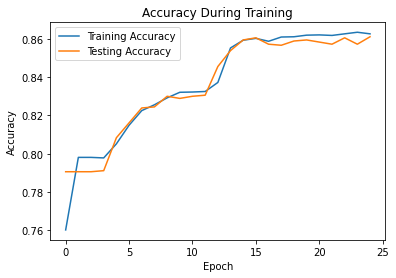

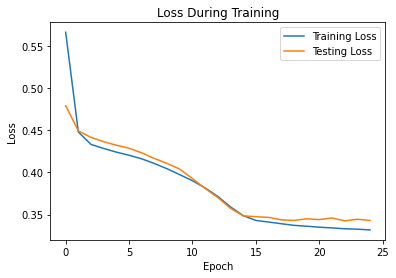

In [78]:
# === Plot the Accuracy === #
plt.figure( )
plt.plot( ann_2_history.history['accuracy']     , label='Training Accuracy' )
plt.plot( ann_2_history.history['val_accuracy'] , label='Testing Accuracy' )

# === Label the Chart === #
plt.xlabel( 'Epoch' )
plt.ylabel( 'Accuracy' )
plt.title( 'Accuracy During Training' )
plt.legend( )

# === Display the Chart === #
plt.show( )


# === Plot the Loss === #
plt.figure( )
plt.plot( ann_2_history.history['loss']     , label='Training Loss' )
plt.plot( ann_2_history.history['val_loss'] , label='Testing Loss' )

# === Label the Chart === #
plt.xlabel( 'Epoch' )
plt.ylabel( 'Loss' )
plt.title( 'Loss During Training' )
plt.legend( )

# === Display the Chart === #
plt.show( )

### Keras ANN 2.4: Evaluate the Model

Compute the same evaluation metrics for ANN-2 based model on the training and test set.

In [79]:
# === Extract Metrics, Archive, and Report === #
ann_2_metrics = evaluate_model( ann_2 , X_train_scaled , y_train , X_test_scaled , y_test )
model_metrics.append( ann_2_metrics )
model_objects.append( ann_2 )
ann_2_metrics

{'conf_mat': {'TP': 169, 'FP': 42, 'TN': 1381, 'FN': 208},
 'accuracy': 0.8611111111030865,
 'precision': 0.8009478672700523,
 'recall': 0.4482758620717095,
 'conf_mat_train': {'TP': 658, 'FP': 190, 'TN': 5556, 'FN': 796},
 'accuracy_train': 0.8630555555535386,
 'precision_train': 0.775943396219907,
 'recall_train': 0.4525447042647518,
 'F1': 0.5748299427647046,
 'F1_train': 0.5716768134719479}

## Task 8: (10 points)

### Keras ANN 3.1: Construct the Layers

* Input layer will still have 11 units as the dimension of training set (i.e, number of columns = 11).
* Hidden-layer-1: 8 neurons, with relu activation
* Hidden-layer-2: 4 neurons, with relu activation,
* Hidden-layer-3: 2 neurons, with relu activation,
* Output-layer: 1 neuron with sigmoid.

In [80]:
'''
Make sure to put all the Keras layers in the layers_3 variable below.
'''
layers_3 = []

# YOUR CODE HERE
#https://gist.github.com/nairouz/5b65c35728d8fb8ec4206cbd4cbf9bea
#https://github.com/keras-team/keras
layers_3 = [ keras.Input( shape=( X_train_scaled[0].shape ) ),  # Input Layer
            keras.layers.Dense(  8 , activation='relu'    , name='hidden-layer-1' ),  
            keras.layers.Dense(  4 , activation='relu'    , name='hidden-layer-2' ),  
            keras.layers.Dense(  2 , activation='relu' , name='hidden-layer-3' ),
            keras.layers.Dense(  1 , activation='sigmoid' , name='output-layer' )  
          ]




### Keras ANN 3.2: Compile the Model

Here, we first created the ANN with the layers according to the specification above, and the network
will be saved in `ann_3` object.

Similarly to the first and second models, you need to compile the model with the `adam` optimizer and the `binary_corssentropy` loss function. And, pass 'accuracy' to be shown during every epoch run of the training process.

In [81]:
# === Define the Model Object === #
ann_3 = keras.Sequential( layers=layers_3 )

# YOUR CODE HERE
#https://gist.github.com/PatrickKalkman/1a05da61d1cf815571b3004c5c041393
ann_3.compile( loss='binary_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy'] )

ann_3.summary()
#raise NotImplementedError()



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden-layer-1 (Dense)      (None, 8)                 96        
                                                                 
 hidden-layer-2 (Dense)      (None, 4)                 36        
                                                                 
 hidden-layer-3 (Dense)      (None, 2)                 10        
                                                                 
 output-layer (Dense)        (None, 1)                 3         
                                                                 
Total params: 145
Trainable params: 145
Non-trainable params: 0
_________________________________________________________________


In [82]:
"""Check if ANN-3 network is compiled according to the specification"""

assert  check_network_architecture(ann_3, 
                                  expected_layer_shapes=[8,4,2,1],
                                  expected_params=145,
                                  expected_loss_function='binary_crossentropy') == True

### Keras ANN 3.3: Train the Model

Now that the model is compiled, it must be trained. In order to compare the model structures directly, both will be trained for the same number of epochs (i.e., 25) and evaluated accordingly.

In [83]:
# === Train While Recording History for Visualization === #
ann_3_history = ann_3.fit( X_train_scaled, 
                           y_train, 
                           epochs=25,
                           validation_data=( X_test_scaled , y_test ) )

Epoch 1/25
225/225 [==============================] - 3s 6ms/step - loss: 0.5632 - accuracy: 0.7981 - val_loss: 0.4949 - val_accuracy: 0.7906
Epoch 2/25
225/225 [==============================] - 1s 4ms/step - loss: 0.4674 - accuracy: 0.7981 - val_loss: 0.4613 - val_accuracy: 0.7906
Epoch 3/25
225/225 [==============================] - 1s 3ms/step - loss: 0.4479 - accuracy: 0.7981 - val_loss: 0.4478 - val_accuracy: 0.7906
Epoch 4/25
225/225 [==============================] - 0s 2ms/step - loss: 0.4378 - accuracy: 0.7981 - val_loss: 0.4406 - val_accuracy: 0.7906
Epoch 5/25
225/225 [==============================] - 0s 2ms/step - loss: 0.4324 - accuracy: 0.7981 - val_loss: 0.4367 - val_accuracy: 0.7906
Epoch 6/25
225/225 [==============================] - 1s 2ms/step - loss: 0.4287 - accuracy: 0.7981 - val_loss: 0.4343 - val_accuracy: 0.7906
Epoch 7/25
225/225 [==============================] - 1s 4ms/step - loss: 0.4263 - accuracy: 0.7981 - val_loss: 0.4310 - val_accuracy: 0.7906
Epoch 

### Keras 3.3: Training Visualization

Let's visualize the training history.

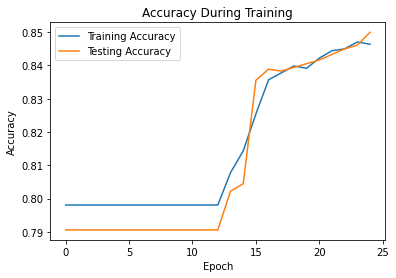

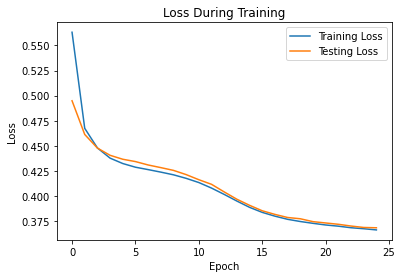

In [84]:
# === Plot the Accuracy === #
plt.figure( )
plt.plot( ann_3_history.history['accuracy']     , label='Training Accuracy' )
plt.plot( ann_3_history.history['val_accuracy'] , label='Testing Accuracy' )

# === Label the Chart === #
plt.xlabel( 'Epoch' )
plt.ylabel( 'Accuracy' )
plt.title( 'Accuracy During Training' )
plt.legend( )

# === Display the Chart === #
plt.show( )


# === Plot the Loss === #
plt.figure( )
plt.plot( ann_3_history.history['loss']     , label='Training Loss' )
plt.plot( ann_3_history.history['val_loss'] , label='Testing Loss' )

# === Label the Chart === #
plt.xlabel( 'Epoch' )
plt.ylabel( 'Loss' )
plt.title( 'Loss During Training' )
plt.legend( )

# === Display the Chart === #
plt.show( )

### Keras ANN 3.4: Evaluate the Model

In order to compare the keras models, and to determine which one to apply on the judgement set, we must compute the same metrics for ANN-3. We can utilized the functions defined earlier to obtain evaluation metrics in the same format as those computed for ANN-1 and ANN-2.

In [85]:
# === Extract Metrics, Archive, and Report === #
ann_3_metrics = evaluate_model( ann_3 , X_train_scaled , y_train , X_test_scaled , y_test )
model_metrics.append( ann_3_metrics )
model_objects.append( ann_3 )
ann_3_metrics

{'conf_mat': {'TP': 170, 'FP': 63, 'TN': 1360, 'FN': 207},
 'accuracy': 0.8499999999922223,
 'precision': 0.72961373388587,
 'recall': 0.450928381965468,
 'conf_mat_train': {'TP': 608, 'FP': 251, 'TN': 5495, 'FN': 846},
 'accuracy_train': 0.8476388888869576,
 'precision_train': 0.707799767166291,
 'recall_train': 0.418156808804427,
 'F1': 0.5573770597338349,
 'F1_train': 0.525724178408802}

## Task 9: (10 points)
### Recreating ANNs Without Keras library -- defining your own ANN


### Custom ANN Class

In order to train a custom neural network, we must create a wrapper class in order to streamline the operations of the network and ensure the recreation of the keras models is done as "painlessly" as possible. 

In [86]:
# ==================================================
# CLASS: MyANN
# ==================================================
# ATTRIBUTES:
# ==================================================
#
#   - input_shape: tuple containing shape of input data
#   - weight: list of numpy arrays (matrices) containing
#             weights of the perceptrons for each layer
#   - bias: list of biases for each layer of the network
#   - activation: strings containing the activation function for
#                 the corresponding layer. Only relu and
#                 sigmoid supported.
#   - functions: dictionary that maps the name of the
#                activation functions to their corresponding
#                member function.
#   - outputs: the (post activation) outputs of each layer
#              corresponding to the last call of 
#              self.feed_forward(). intended for internal
#              use only
#   - deltas: the error to be propagated into the corresponding
#             layers of the network at the most recent training
#             step. Intended for internal use only
#
# ==================================================
# CONSTRUCTOR
# ==================================================
#
# input: 
#   * N/A
#
# output: 
#   * N/A
#
# Task:
#   * initialize attributes and seed the random
#     numbers for consistent replication.
#
# ==================================================
# MEMBER FUNCTION: relu( x )
# ==================================================
#
# Input:
#   - x: the numpy array to apply the relu function to
#
# Output:
#   - the results of performing relu on the input
#
# Task:
#   - define the relu function:
#        f(x) = max(0,x)
#
# ==================================================
# MEMBER FUNCTION: sigmoid( x )
# ==================================================
#
# Input:
#   - x: numpy array to apply the sigmoid function to
#
# Output:
#   - return the results of passing the input through
#     the sigmoid function
#
# Task:
#   - Pass the given input into the sigmoid function
#        f(x) = 1 / ( 1 - e^(-x) )
#
# ==================================================
# MEMBER FUNCTION: add_input( input_shape )
# ==================================================
#
# Input:
#   - input_shape: tuple containing the shape of the input
#
# Output:
#   - N/A
#
# Task:
#   - set the input_shape attribute to match input
#
# ==================================================
# MEMBER FUNCTION: add_layer( n_nodes , activation )
# ==================================================
#
# Input:
#   - n_nodes: integer representing number of nodes in
#              the layer being added
#   - activation: string indicating which activation
#              function to use
#
# Output:
#   - N/A
#
# Task:
#   - Add an appropriately shapped matrix to the
#     weight attribute for the connections to the
#     previous layer. Weights randomly initialized
#   - Add a bias of 1 to the previous layer
#   - Add the current layer's activation
#   - 
# ==================================================
# MEMBER FUNCTION: compute_loss_gradient( pred , truth )
# ==================================================
#
# Input:
#   - pred: the computed value of the network output
#   - truth: the expected output of the network
#
# Output:
#   - the results of the gradient for binary corssentropy
#     (gradient used for minimizing that loss function)
#
# Task:
#   - return the gradient of the binary crossentropy 
#        * log-loss
#
# Notes:
#   - Binary Crossentropy Function:
#       f(x) = -y*log(z) - (1-y)*log(1-z)
#       Where y=truth, z=pred
#   - Piecewise Binary Crossentropy:
#       f(x) = { -log(z) if y=1; -log(1-z) otherwise; }
#   - Gradient of Binary Crossentropy:
#       f(x) = -(y/z) + (1-y)/(1-z)
#   - Piecewise Gradient of Binary Crossentropy:
#       f(x) = { -1/z if y=1; 1/(1-z) otherwise; }
#   - The piecewise gradient is used for this function
#
# ==================================================
# MEMBER FUNCTION: transfer_derivative( output , activation )
# ==================================================
#
# Input:
#   - output: the output of the neurons in the layer being
#             transferred
#   - activation: the activation function the neurons used
#
# Output:
#   - return the determined scale by which the error should be
#     transferred to the previous weights in the network
#
# Task:
#   - Using chain rule on the activation function, determine 
#     the factor by which the loss should be transferred
#     to the previous layer in backpropagation
#   - Return this value
#     
# ==================================================
# MEMBER FUNCTION: feed_forward( row )
# ==================================================
#
# Input:
#   - row: row of the data to be passed through
#          the feed forward algorithm
#
# Output:
#   - the result of a series of biased matrix multiplications
#     starting with the given row
#
# Task:
#   - multiply the row through the weights matricies with
#     dot product, activate the neurons, apply the bias,
#     and treat those values as inputs to the next layer
#   - archive each layer's output and an initialized delta
#     as member attributes for use in training.
#   - return the final results of the final activation
#
# ==================================================
# MEMBER FUNCTION: back_propagate( row , target )
# ==================================================
#
# Input:
#   - row: data row being used for backpropagation
#   - target: expected output used for computing loss
#
# Output:
#   - N/A
#
# Task:
#   - compute the overall loss gradient
#   - using chain rule, pass the loss backwards
#     through layers with appropriate scaling
#   - record these values for each layer as the
#     deltas member attribute for weight updating
#
# ==================================================
# MEMBER FUNCTION: update_weights( row , learning_rate )
# ==================================================
#
# Input:
#   - row: data row being used in current training step
#   - learning rate: scale by which computed deltas 
#        affect weights.
#
# Output:
#   - N/A
#
# Task:
#   - Iterate through the layers of the network
#   - scale each weight by learning rate times 
#     backpropagation delta times degree of the 
#     input affecting that weight
#
# ==================================================
# MEMBER FUNCTION: fit( X_train , y_train , epochs , learning_rate )
# ==================================================
#
# Input:
#   - X_train: dataset to be used for training
#   - y_train: target labels corresponding to X_train
#   - epochs: number of epochs (complete passes through dataset)
#   - learning rate (optional): speed of learning
#        * default = None
#        * if None, it's initialized to 1/(2*num_weights)
#          meaning, it is proportional to the number of weights
#          to be trained if not statically specified
#
# Output:
#   - N/A
#
# Task:
#   - Iterate through the rows of X_train a total of 
#     epochs times
#   - for each row, backpropagate that row, and update
#     the weights based on backpropagation results
#        * Stochastic Gradient Descent -- update each row
#
# ==================================================
# MEMBER FUNCTION: predict( X )
# ==================================================
#
# Input:
#   - X: dataset to be predicted (assumed to be
#        appropriately shaped rows)
#
# Output:
#   - Numpy 2d array where each row contains the predicted
#     target variable for each corresponding row in X
#
# Task:
#   - perform the feed_forward function for each row
#     row of X without the archiving for training
#   - format the results appropriately and return
#
# ==================================================
class MyANN:
    
    # ==============================================
    # CONSTRUCTOR
    # ==============================================
    def __init__( self ):
        np.random.seed( random_seed )
        self.input_shape = None
        self.weight      = [ ]
        self.bias        = [ ]
        self.activation  = [ ]
        self.functions   = {
            'relu'    : self.relu,
            'sigmoid' : self.sigmoid
        }
        return
    
    
    # ==============================================
    # MyANN.relu( x )
    # ==============================================
    def relu( self , x ):
        tmp = x.copy( )
        tmp[tmp <= 0] = 0  # can't use max() because "truth value of an array is unknown"
        return tmp
    
    
    # ==============================================
    # MyANN.sigmoid( x )
    # ==============================================
    def sigmoid( self , x ):
        return 1 / ( 1 + np.exp( x ) )
    
    
    # ==============================================
    # MyANN.add_input( input_shape )
    # ==============================================
    def add_input( self , input_shape ):
        self.input_shape = input_shape
        return
    
    
    # ==============================================
    # MyANN.add_layer( n_nodes , activation )
    # ==============================================
    def add_layer( self , n_nodes , activation ):
        
        # === If First Hidden Layer, Use Input Shape === #
        if len( self.weight ) == 0:
            if self.input_shape is None:  # dismiss if no input layer
                return -1
            prev_shape = self.input_shape
        
        # === Otherwise, Use Shape of Previous Layer's Output === #
        else:
            prev_shape = self.weight[-1].shape[-1]
            
        # === Assign Bias=1 and Random Weights of Specified Dimension with Activation Given === #
        bias    = 1
        weights = np.random.rand( prev_shape+1 , n_nodes ) / (prev_shape+1) # +1 for bias
        
        # === Archive the Values === #
        self.weight.append( weights )
        self.bias.append( 1 )  # simple network, all biases are 1
        self.activation.append( activation )  # assuming string
        return  # MyANN.add_layer( )
    
    
    # ==============================================
    # MyANN.compute_loss_gradient( pred , truth )
    # ==============================================
    def compute_loss_gradient( self , pred , truth ):  # gradient of binary crossentropy
        
        # === y=1: -1/z (or -inf if z is zero to prevent error) === #
        if truth == 1:
            if pred == 0:  # avoid divide by 0
                return -np.inf
            else:
                return -1 / pred
            
        # === y=0: 1/(1-z) (or +inf if z is 1 to prevent error) === #
        else:
            if pred == 1:  # avoid divide by 0
                return np.inf
            else:
                return 1 / ( 1 - pred )
            
            
    # ==============================================
    # MyANN.transfer_derivative( output , activation )
    # ==============================================
    def transfer_derivative( self , output , activation ):
        
        # === ReLU Chain Rule: 0 if Output was 0, 1 Otherwise === #
        if activation == 'relu':
            tmp = output.copy( )
            tmp[tmp <= 0] = 0
            tmp[tmp >  0] = 1
            return tmp  # derivative of relu: linear when >0 flat <=0
        
        # === Sigmoid Chain Rule: s(x)*(1-s(x)) === #
        elif activation == 'sigmoid':
            return output * ( 1 - output )
        
        # === Failsafe for Invalid Activations === #
        else:
            return 0  # shouldn't ever get here, but just in case
    
    
    # ==============================================
    # MyANN.feed_forward( row )
    # ==============================================
    def feed_forward( self , row ):
        
        # === Initialization === #
        self.bias[-1] = 0    # no bias at final layer
        self.outputs  = [ ]  # reset neuron outputs for training
        self.deltas   = [ ]  # to be used in backpropagation
        pivot         = row.copy( )
        
        # === Iterate Through the Layers === #
        for i in range( len( self.weight ) ):
            
            # === Add the Bias === #
            pivot = np.append( pivot , self.bias[i] )
            
            # === Dot Product (Weighted Sum) === #
            pivot = np.dot( pivot , self.weight[i] )
            
            # === Activate Neurons === #
            pivot = self.functions[ self.activation[i] ]( pivot )
            
            # === Archive Appropriate Values === #
            self.outputs.append( pivot )  # keep record of all activated outputs
            self.deltas.append( np.zeros( len( pivot ) ) )  # initializing deltas for later
            
        # === Return Output of Final Layer === #
        return pivot[0]  # MyANN.feed_forward( )
    
    
    # ==============================================
    # MyANN.back_propagate( row , target )
    # ==============================================
    def back_propagate( self , row , target ):
        
        # === Feed Forward to Initialize === #
        self.feed_forward( row )
        
        # === Iterate Backwards Through Layers === #
        for i in reversed( range( len( self.weight ) ) ):
            
            # === Output Layer: No Need for Chain Rule === #
            if i == len( self.weight ) - 1:
                error = self.compute_loss_gradient( self.outputs[i] , target )
                
            # === Not Output Layer: Scale Error by Weight (dot) Previous Layer Deltas === #
            else:
                error = np.dot( self.weight[i+1][:-1] , self.deltas[i+1] )
            
            # === Use Chain Rule to Determine Current Layer's Deltas === #
            self.deltas[i] = error * self.transfer_derivative( self.outputs[i] , self.activation[i] )
            
        return  # MyANN.back_propagate( )
    
    
    # ==============================================
    # MyANN.update_weights( row , learning_rate )
    # ==============================================
    def update_weights( self , row , learning_rate ):
        
        # === Initialize === #
        inputs = row
        
        # === Iterate Layers === #
        for i in range( len( self.weight ) ):
            
            # === If Hidden Layer, Use Previous Layer's Output as Input === #
            if i != 0:
                inputs = self.outputs[i-1]
                
            # === Apply Bias === #
            inputs = np.append( inputs , self.bias[i] )
            
            # === Scale Each Weight Appropriately === #
            for j in range( len( inputs ) ):
                self.weight[i][j] += learning_rate * self.deltas[i] * inputs[j]
                
        return  # MyANN.update_weights( )
    
    
    # ==============================================
    # MyANN.train( X_train , y_train , epochs , learning_rate )
    # ==============================================
    def fit( self , X_train , y_train , epochs , learning_rate=None ):
        
        # === Initialize Learing Rate if Needed === #
        if learning_rate is None:
            params        = np.sum( [w.shape[0]*w.shape[1] for w in self.weight] )
            learning_rate = 1 / ( 2 * params )  # LR is proportionally smaller than num_params
            
        # === Ensure No Output Layer Bias to Outweight Network === # 
        self.bias[-1] = 0  # no bias performed at output layer
        
        # === Each Epoch is 1 Pass Through X_train Rows === #
        for e in range( epochs ):
            print( 'Epoch {}...'.format( e+1 ) )
            
            # === Stochastic Gradient Descent: Backpropagate and Update Weights Each Row === #
            for i in range( len( X_train ) ):
                self.back_propagate( X_train[i] , y_train[i] )
                self.update_weights( X_train[i] , learning_rate )
               
            
    # ==============================================
    # MyANN.predict( X )
    # ==============================================
    def predict( self , X ):
        
        # === Initialization of Output Array === #
        output = np.zeros( ( len( X ) , 1 ) )
        
        # === Perform for Each Row of X === #
        for i in range(len(X)):
            
            # === Feed-Forward Algorithm === #
            pivot = X[i].copy( )
            for j in range( len( self.weight ) ):
                pivot = np.append( pivot , self.bias[j] )
                pivot = np.dot( pivot , self.weight[j] )
                pivot = self.functions[ self.activation[j] ]( pivot )
                
            # === Record Results for Output === #
            output[i,0] = pivot[0]
            
        # === Return Final Output === #
        return output  # MyANN.predict( )
    
    def get_layers(self):
        #print(len(self.weight))
        layers = []
        for i in np.arange(len(self.weight)):
            #print(self.weight[i].shape)
            layers.append(self.weight[i].shape[1])
        return layers
        
        

## Recreating ANN-1 Without Keras

Let's construct `myANN1` object of type `MyANN` defined above. The architecture of myANN1 will have the same structure as the Keras `ann_1` model we constructed before.

Also, call the `fit()` method to train on the training dataset for 25 epochs.

In [87]:
myANN1 = MyANN( )
myANN1.add_input( X_train_scaled[0].shape[0] )
myANN1.add_layer(  5 , 'relu'    )
myANN1.add_layer(  4 , 'relu'    )
myANN1.add_layer(  1 , 'sigmoid' )

''' Now begin the training on the training set (X_train_scaled, y_train)'''
myANN1.fit( X_train_scaled , np.array(y_train,dtype=int) , 2 )

Epoch 1...
Epoch 2...


In [88]:
'''
An utility function to check number of layers defined in any MyANN object.
'''
def check_myANN_layers(model, expected_layers):
    so_far_so_good = False
    if isinstance(model,MyANN) and model.get_layers()==expected_layers:
        so_far_so_good = True
    return so_far_so_good

In [89]:
''' Checking if the myANN1 object has the correct architecture.
'''
assert check_myANN_layers(myANN1,expected_layers=[5,4,1]) == True

## Evaluating myANN1 on the Test Set

We will now evaluate the test performance of the custom model, `myANN1` on the test dataset. 

In [90]:
# === Extract Metrics, Archive, and Report === #
myann_1_metrics = evaluate_model( myANN1 , X_train_scaled , y_train , X_test_scaled , y_test )
model_metrics.append( myann_1_metrics )
model_objects.append( myANN1 )
myann_1_metrics

{'conf_mat': {'TP': 63, 'FP': 9, 'TN': 1414, 'FN': 314},
 'accuracy': 0.8205555555484322,
 'precision': 0.8749999998958333,
 'recall': 0.16710875333330988,
 'conf_mat_train': {'TP': 215, 'FP': 50, 'TN': 5696, 'FN': 1239},
 'accuracy_train': 0.8209722222204391,
 'precision_train': 0.8113207546934852,
 'recall_train': 0.14786795048627419,
 'F1': 0.2806236226516733,
 'F1_train': 0.25014544818154955}

## Constructing ANN-2 with the custom MyANN class.

similar to `myANN1`, we will do the same for `myANN2`, which consists of four relu layers with 8 units each, and a single sigmoid layer for output, similar to `ann_2` (the Keras model).

In [91]:
'''
Let's construct myANN2, similar to the Keras model, ann_2 that we've constructed before, using MyANN class.
Also, call the fit function of myANN2 object and train with training dataset for 25 epochs.
'''
myANN2 = MyANN( )

# YOUR CODE HERE
#https://towardsdatascience.com/building-our-first-neural-network-in-keras-bdc8abbc17f5
myANN2.add_input( X_train_scaled[0].shape[0] )
myANN2.add_layer(  8 , 'relu'    )
myANN2.add_layer(  8 , 'relu'    )
myANN2.add_layer(  8 , 'relu'    )
myANN2.add_layer(  8 , 'relu'    )
myANN2.add_layer(  1 , 'sigmoid' )

''' Now begin the training on the training set (X_train_scaled, y_train)'''
myANN2.fit( X_train_scaled , np.array(y_train,dtype=int) , 25 )

Epoch 1...
Epoch 2...
Epoch 3...
Epoch 4...
Epoch 5...
Epoch 6...
Epoch 7...
Epoch 8...
Epoch 9...
Epoch 10...
Epoch 11...
Epoch 12...
Epoch 13...
Epoch 14...
Epoch 15...
Epoch 16...
Epoch 17...
Epoch 18...
Epoch 19...
Epoch 20...
Epoch 21...
Epoch 22...
Epoch 23...
Epoch 24...
Epoch 25...


In [92]:
''' Checking if the myANN2 object has the correct architecture.
'''
assert check_myANN_layers(myANN2,expected_layers=[8,8,8,8,1]) == True

## Evaluating MyANN2

We will now evaluate the test performance of the custom model, `myANN2` on the test dataset. 

In [93]:
# === Extract Metrics and Report === #
myann_2_metrics = evaluate_model( myANN2 , X_train_scaled , y_train , X_test_scaled , y_test )
model_metrics.append( myann_2_metrics )
model_objects.append( myANN2 )
myann_2_metrics

{'conf_mat': {'TP': 96, 'FP': 23, 'TN': 1400, 'FN': 281},
 'accuracy': 0.8311111111037531,
 'precision': 0.8067226890240803,
 'recall': 0.2546419098273399,
 'conf_mat_train': {'TP': 356, 'FP': 105, 'TN': 5641, 'FN': 1098},
 'accuracy_train': 0.8329166666648171,
 'precision_train': 0.7722342733070614,
 'recall_train': 0.24484181568439012,
 'F1': 0.38709678690833105,
 'F1_train': 0.3718015792711274}

## Recreating ANN-3 Without Keras

Finally, using the same class again, we will train a model with the same network structure as the `ann_3` keras model. 

In [94]:
myANN3 = MyANN( )
#https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU
# YOUR CODE HERE
myANN3.add_input( X_train_scaled[0].shape[0] )
myANN3.add_layer(  8 , 'relu'    )
myANN3.add_layer(  4 , 'relu'    )
myANN3.add_layer(  2 , 'relu'    )
myANN3.add_layer(  1 , 'sigmoid' )

''' Now begin the training on the training set (X_train_scaled, y_train)'''
myANN3.fit( X_train_scaled , np.array(y_train,dtype=int) , 25 )

Epoch 1...
Epoch 2...
Epoch 3...
Epoch 4...
Epoch 5...
Epoch 6...
Epoch 7...
Epoch 8...
Epoch 9...
Epoch 10...
Epoch 11...
Epoch 12...
Epoch 13...
Epoch 14...
Epoch 15...
Epoch 16...
Epoch 17...
Epoch 18...
Epoch 19...
Epoch 20...
Epoch 21...
Epoch 22...
Epoch 23...
Epoch 24...
Epoch 25...


In [95]:
''' Checking if the myANN3 object has the correct architecture.
'''
assert check_myANN_layers(myANN3,expected_layers=[8,4,2,1]) == True

## Evaluating MyANN3

We will now evaluate the test performance of the custom model, `myANN3` on the test dataset.

In [96]:
# === Extract Metrics and Report === #
myann_3_metrics = evaluate_model( myANN3 , X_train_scaled , y_train , X_test_scaled , y_test )
model_metrics.append( myann_3_metrics )
model_objects.append( myANN3 )
myann_3_metrics

{'conf_mat': {'TP': 94, 'FP': 26, 'TN': 1397, 'FN': 283},
 'accuracy': 0.8283333333260371,
 'precision': 0.7833333332861111,
 'recall': 0.24933687003982294,
 'conf_mat_train': {'TP': 361, 'FP': 104, 'TN': 5642, 'FN': 1093},
 'accuracy_train': 0.8337499999981458,
 'precision_train': 0.7763440860096196,
 'recall_train': 0.24828060523042259,
 'F1': 0.3782696303899856,
 'F1_train': 0.376237636421045}

## Task 10 (15 points = 5 + 5 + 5)
* Best model, judge and evaluation

## Choosing the Best Model

Now that we have all the metrics archived for evaluating our models on the test partition of the dataset, we can objectively compare them all and determine which model is objectively the "best"

For the purposes of this assignment, we will be using the accuracy metric as the objective measure of the "best" model. Whichever model is capable of producing the highest accuracy will be packaged and sent to the other submission file to be used on the judgement set.

In [97]:
# === Initialize Mode/Metrics === #
model   = ann_1
metrics = ann_1_metrics

# === Compare Against all Models to Find the "Best" === #
for i in range( len( model_metrics ) ):
    if metrics['accuracy'] < model_metrics[i]['accuracy']:
        model   = model_objects[i]
        metrics = model_metrics[i]

# === Report Accuracy of "Best" Model === #
print( 'Best Accuracy: {}'.format( metrics['accuracy'] ) )

Best Accuracy: 0.8611111111030865


## Saving the Objects for Use Against Judgement

Now that we have determined the best model with respect to test accuracy, we will  --

* save the model object along with the encoders, standard scaler (i.e., normalizer) that was fit in the preprocessing step. That way we can encode and scale any test/judgement dataset later according to the same metrics as we did the other datasets without reloading/re-fitting/re-training the model. 

* In order to save these objects, we will use python's `pickle` package.

In [98]:
# === If MyANN Model is Best, Pickle the Model === #
if isinstance( model , MyANN ):
    dump( model , open( 'dataset/model.sav' , 'wb' ) )
    # === Otherwise, Keras model.save( ) === #
else:
    model.save( 'dataset/model.sav', save_format='h5' )
    
# === Pickle to Save the OneHotEncoders=== #
dump( [enc_list,categorical_features], open( 'dataset/onehotencoder.pkl' , 'wb' ) )
    
# === Pickle to Save the Normalizer === #
dump( normalizer , open( 'dataset/normalizer.pkl' , 'wb' ) )



In [99]:
'''
Check if you have saved the objects mentioned above.
'''
model_file = Path("dataset/model.sav")
onehotencoder_file = Path("dataset/onehotencoder.pkl")
normalizer_file = Path("dataset/normalizer.pkl")

assert model_file.is_file() and onehotencoder_file.is_file() and normalizer_file.is_file() == True


## Working with the judge.csv based evaluation
The following cells contain documented judgement code for the assignment, as specified by the assignment instructions. 

## Preprocessing the Dataset

In the training file, some preprocessing was performed to the dataset prior to training the model. 

In order to ensure the model (i.e., the best model) predicts the output appropriately, it must be preprocessed similarly to the training methods. 

The following cells perform these transformations on the judgement set. 

In [100]:
'''
Reading the judge.csv dataset... it's similar to test set, without the target column.
This is the same scenario you would encounter in real-world problems... 
    * You are given dataset with targets labels... you build a model... you do test evaluations...
        you pick your best model ... and then you are out in the wild... 
            wanting to predict real/unknown samples... without prior information.
'''
# === Use the Above Function and Demonstrate Success === #
judge_dataset = read_dataset( 'dataset/judge.csv' )


### Do the following three preprocessings on the judge_dataset:
1. First preprocessing is Dropping  Features: {CustomerID, Surname}.
2. Fifth preprocessing is to One hot encoding based on the judge_set
    * Make sure you use the onehot-encoders you've saved before.
3. Sixth preprocessing is Normalization
    * Make sure you use the normalizer you've saved before.

In [101]:
'''
1. First preprocessing is dropping 'CustomerID' and 'Surname' columns from judge_dataset. Save the resulting
    dataset as judge_first.
2. Fifth preprocessing is one-hot encoding of the judge_first dataset using the same encoders on the 
    same categorical features you've encoded the training set. Save the resulting dataset as judge_fifth.
3. Sixth preprocessing is normalizing the judge_fifth dataset based on the the same normalizer you applied 
    on training/test set. Save the resulting dataset as judge_sixth.
'''
# YOUR CODE HERE
#https://gist.github.com/vidit0210/c2f74323c8d2096729000f98ffbee4ac
#https://github.com/pemagrg1/one-hot-encoding/blob/master/one_hot_encoding_using_Tensorflow.py
#https://github.com/kmedian/onehot
#https://github.com/AmoDinho/datacamp-python-data-science-track/blob/master/Supervised%20Learning%20with%20scikit-learn/Chapter%204%20-%20Preprocessing%20and%20pipelines.py
customer_id = judge_dataset["CustomerId"]
judge_dataset.drop(["CustomerId","Surname"],axis=1,inplace=True)

judge_fifth = lets_do_one_hot_encoding(judge_dataset, categorical_features,True,enc_list)[0]
judge_Sixth = normalizer.transform(judge_fifth)
#raise NotImplementedError()

In [102]:
'''
Checking if the 3 judge dataset preprocessing are done correctly. I'm here checking only one-hot encoding.
'''
assert  check_one_hot_encoding(X_train_ohe,judge_fifth) == True



## Load the Best Model to predict the judge samples

In the training notebook, we saved our best performing model as `model.sav`. 

Please note, `model.sav` file could be either a `MyANN` object, or `Keras` model. Loading function to these
two types are different. So, let's first try with `pickle.load`, and if it throws an exception, then
we will try to load it via `Keras` model load function.


In [103]:
try:
    model = load(open('dataset/model.sav','rb'))
except:
    model = keras.models.load_model( 'dataset/model.sav' )


## Task (5 points)
### Predict 1 and 0 for all the samples in the judge_sixth dataset.

Please note, your prediction results should be either 0 or 1. Fractions are not allowed.

Also, prepare a pandas dataframe, judge_pred_df containing 2 columns: {CustomerId, Exited}.
The dataframe will contain CustomerId and corresponding predicted 0/1 values according to your best model evaluation.



In [104]:
'''
Prepare prediction of the judge_sixth preprocessed set using the best model.
Save your prediction results in judge_pred variable.
Make sure the judge_pred contains only 0 and 1. No fractions will be allowed.
Also, make sure number of items in judge_pred matches the number of samples in the judge set.
'''
judge_pred = []
tolerance = 0.5

# YOUR CODE HERE
#https://github.com/ozlerhakan/datacamp/blob/master/Supervised%20Learning%20with%20scikit-learn/Preprocessing%20and%20pipelines.ipynb
y_pred = model.predict( judge_Sixth )

y_pred[y_pred >= tolerance] = 1
y_pred[y_pred <  tolerance] = 0
y_pred  = np.array( y_pred , dtype=int )

judge_pred_df = pd.DataFrame()
judge_pred_df["CustomerId"] =customer_id
judge_pred_df["Exited"] = y_pred

In [105]:
'''
Saving the judge_pred_df dataframe into 'dataset/judge_pred_df.csv' file.
'''
judge_pred_df.to_csv( 'dataset/judge_pred_df.csv' , index=False )

In [106]:
'''
Checking your judge predictions to put some score.


'''
#csv_student_file = open("dataset/judge_pred_df.csv", "rb")
#test_response = requests.post("http://54.160.44.72/csci5931sp22/check-PA1-judge-pred.php", 
#                              files = {"judge_pred": csv_student_file})
files = {'judge_pred': open('dataset/judge_pred_df.csv', 'rb')}


response = requests.post(
                       url='http://54.160.44.72/csci5931sp22/check-PA1-judge-pred.php', 
                       files=files,
                        data = {'submit':'submit'})


assert response.ok == True
print(response.text)

#    print("Upload completed successfully!")
#    print(test_response.text)
#else:
#    print("Something went wrong!")
    

Accuray of your model is 86.4%
Confusion-Matrix:[TP = 101, TN = 763, FP = 31, FN = 105]


